# Explore vs. exploit

Here, we investigate different strategies for how to make the suggestion for the next
point to sample.

This notebook is a part of the series about using ProcessOptimizer to guide a gold
mining expedition. For an overview, go to the markdown file gold_mining.md

## What we learned last time
We define our map by setting `coordinates`, and our `score()` function. We then
initialise a ProcessOptimizer on the `coordinates`. We then do 10 cycles of asking for
a place to dig, sending Ms. Dixon's team to dig, and telling the ProcessOptimizer how
much gold was found.

Lastly, we plot the **secret** gold map, so we can evaluate whether the models built
look like the actual scoring function.

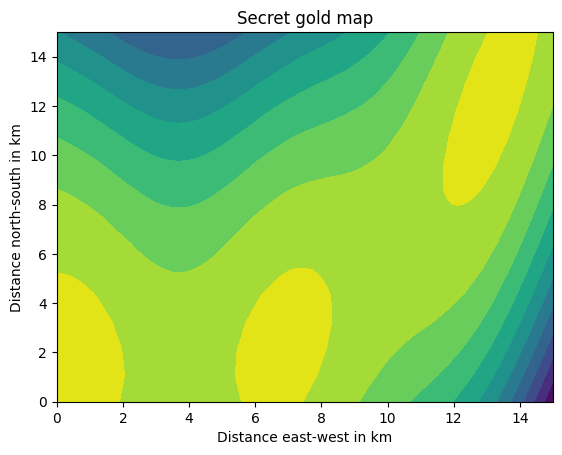

In [17]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import ProcessOptimizer
from ProcessOptimizer.model_systems.model_system import ModelSystem

#Setting random seed to ensure reproducible behaviour
np.random.seed(42)

VERBOSE = False

coordinates = [(0, 15.0),(0,15.0)]

num_digs = 10

def score(coordinates: List[int]):
    """ Modified Branin-Hoo function. It has three local minima.
    More details: <http://www.sfu.ca/~ssurjano/branin.html>
    """
    x = 10-coordinates[0]
    y = coordinates[1]
    gold_found = ((y - 1/8 * x ** 2 + 1.6 * x - 6) ** 2 + 10 * np.cos(x) - 299)/100
    if VERBOSE:
        print(f"We dug at {coordinates} and found {-round(gold_found*10)/10} mg gold.")
    return gold_found

data_model = ModelSystem(score=score,space=coordinates,noise_model="zero")

opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
# For each of the first 10 positions
for index in range(10):
    # Find the place to dig
    new_dig_site = opt.ask()
    # Digging for gold
    gold_found = data_model.get_score(new_dig_site)
    # Telling the optimiser how uch gold we found
    result = opt.tell(new_dig_site, gold_found)

x_list = np.linspace(coordinates[0][0],coordinates[0][1],100)
y_list = np.linspace(coordinates[1][0],coordinates[1][1],15,100)

(x_mesh,y_mesh) = np.meshgrid(x_list,y_list)
score_mesh = [[-data_model.get_score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]
plot = plt.contourf(x_mesh,y_mesh,score_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Secret gold map");

## What to value when picking the next point

The next time Ms. Dixon goes to the office, she gets into an argument with a colleague,
Mr. Map Drawson. Ms. Dixon wants to go out anddig where she expects to find the most
gold, while Mr. Drawson is more interested in the knowledge the dig gives them of the
plot of land.

These two approaches is known as **Exploit** (Ms. Dixons's approach), where we value
getting a good result over getting more knowlegde, and **Explore** (Mr. Drawsons's
approach), where we value reducing uncertainties about how good different parameter
settings are. It isn't a dichotomy where we have to choose one or the other, we can
choose different balances between the two considerations.

The balance is determined by the property of ProcessOptimizer `acq_func_kwargs`, which
is a `dict`. in the default ProcessOptimizer, the value of `acq_func_kwargs["xi"]`
determines where the balance lies. the lower the value, the more XXX the
ProcessOptimizer becomes.

Let's first run it with the defult settings, where `xi = 0.01`, so we have something to
compare the other settings to.

We dug at [5.598121201081679, 1.1773479015203674] and found 3.0 mg gold.
We dug at [13.714359663758247, 12.008554995781704] and found 3.0 mg gold.
We dug at [0.0, 1.6898419495425168] and found 3.1 mg gold.
We dug at [11.173645772773632, 15.0] and found 2.5 mg gold.
We dug at [0.0, 5.6851353251481225] and found 3.0 mg gold.
We dug at [15.0, 15.0] and found 2.9 mg gold.
We dug at [8.36324032914499, 0.0] and found 2.9 mg gold.
We dug at [14.983777788104943, 9.522865957632177] and found 2.4 mg gold.
We dug at [12.07516052517733, 9.513578877609126] and found 3.0 mg gold.
We dug at [1.8026950049262251, 0.0] and found 3.0 mg gold.


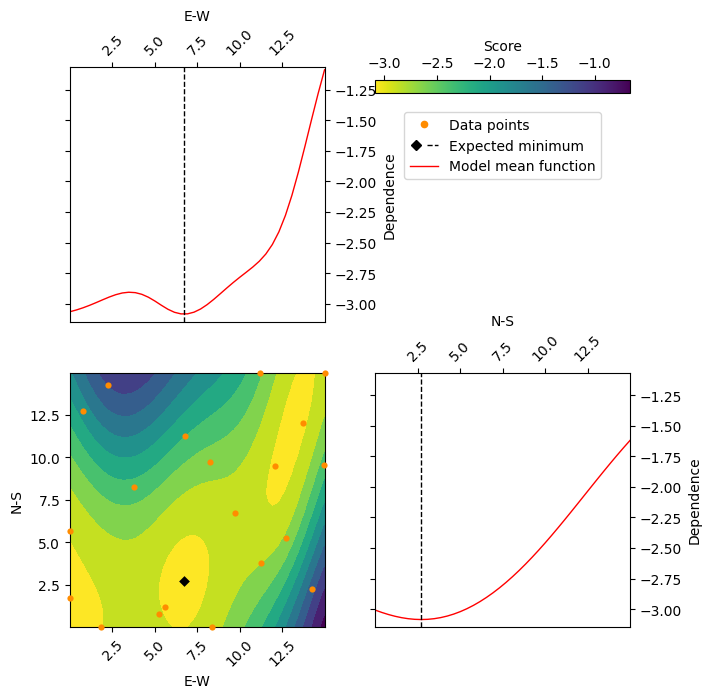

In [18]:
VERBOSE = True
default_opt = opt.copy()
default_opt.acq_func_kwargs = {"xi": 1}
for _ in range(num_digs):
    new_point = default_opt.ask()
    gold_found = data_model.get_score(new_point)
    result = default_opt.tell(new_point,gold_found)
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"]);

## Exploiting

Now let's try a more exploiting ProcessOptimizer. to do this, we set `xi` much lower
than the default.

We dug at [5.598121226368274, 1.177347768670728] and found 3.0 mg gold.
We dug at [5.658043147211417, 1.250473690645196] and found 3.0 mg gold.
We dug at [13.59373160883463, 12.021847079514698] and found 3.1 mg gold.
We dug at [0.0, 1.9398460204791972] and found 3.1 mg gold.
We dug at [12.195803875888425, 9.674322160523433] and found 3.0 mg gold.
We dug at [15.0, 15.0] and found 2.9 mg gold.
We dug at [11.691610313538021, 15.0] and found 2.6 mg gold.
We dug at [13.295330832139797, 10.887826015876135] and found 3.1 mg gold.
We dug at [7.715325775915669, 0.0] and found 3.0 mg gold.
We dug at [6.664081141049428, 2.077814135401489] and found 3.1 mg gold.


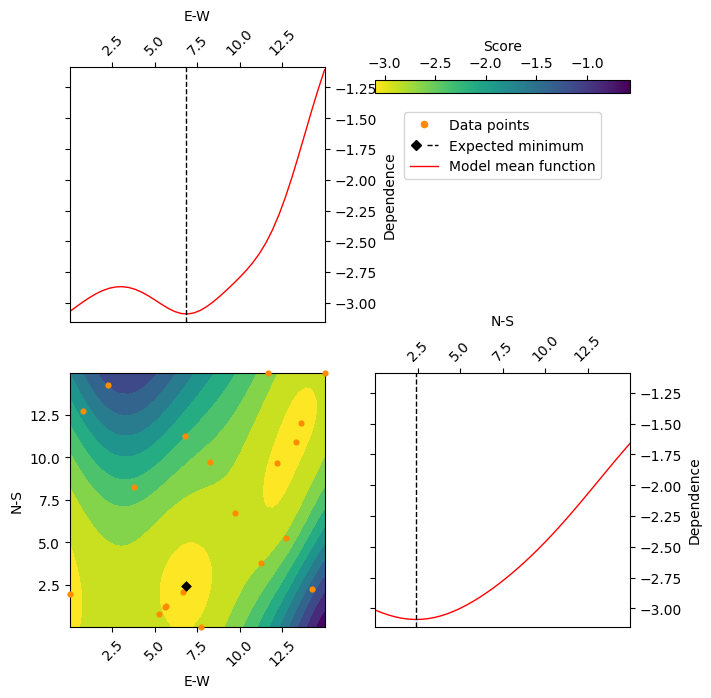

In [19]:
exploiting_opt = opt.copy()
exploiting_opt.acq_func_kwargs = {"xi": 0.00001}
for _ in range(num_digs):
    new_point = exploiting_opt.ask()
    gold_found = data_model.get_score(new_point)
    result = exploiting_opt.tell(new_point,gold_found)
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"]);


Notice that the amount of gold found is higher than for the default. In particular, the
default suggested one dig at `[14.983777788104943, 9.522865957632177]`, where only 2.4
mg gold was found.

On the other hand, the model is a worse fit than the model for the default. The optimum
in the lower left s not well described. Nearly half of the suggestions are near the
optimum in the lower middle, 

So the exploiting ProcessOptmizer is less adventurous, but tends to give better results
for the parameters is suggest.

## Exploring

Now let's try and build an exploring ProcessOptimizer instead. To do this, we set `xi`
higher than the default of 0.01.

We dug at [7.212686726575167, 2.9286651622804545] and found 3.1 mg gold.
We dug at [14.310273029457791, 11.897643053747835] and found 2.9 mg gold.
We dug at [12.19283556235232, 0.7136487947613437] and found 2.2 mg gold.
We dug at [0.0, 0.0] and found 3.0 mg gold.
We dug at [14.00537328048962, 4.235860838762309] and found 2.0 mg gold.
We dug at [8.306456770428174, 9.391063880189376] and found 2.7 mg gold.
We dug at [7.782325020902831, 7.363703785858291] and found 2.9 mg gold.
We dug at [12.504168922976428, 15.0] and found 2.9 mg gold.
We dug at [8.021506115238127, 3.6880207815367574] and found 3.0 mg gold.
We dug at [0.0, 4.683708465808795] and found 3.0 mg gold.


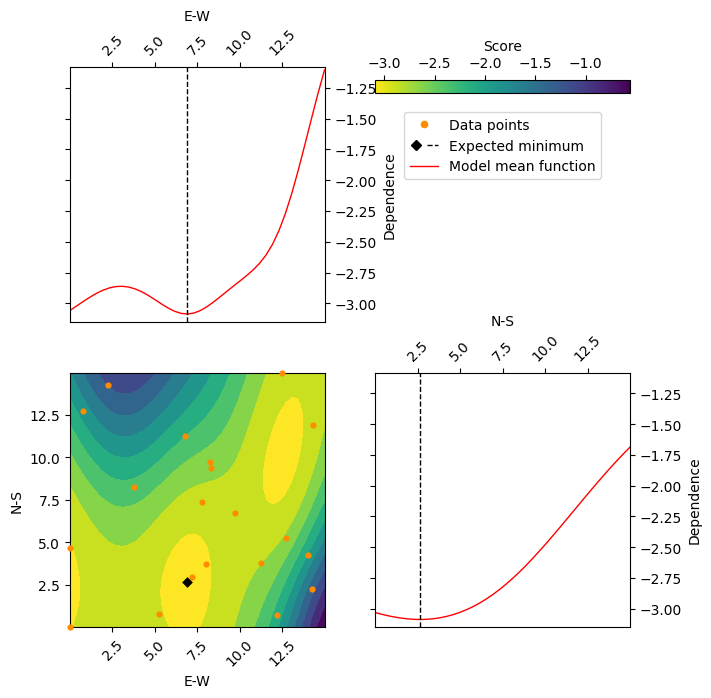

In [20]:
exploring_opt = opt.copy()
exploring_opt.acq_func_kwargs = {"xi": 1000000}
for _ in range(num_digs):
    new_point = exploring_opt.ask()
    gold_found = data_model.get_score(new_point)
    result = exploring_opt.tell(new_point,gold_found)
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"]);
